In [1]:
!pip install tensorflow tensorflow-datasets opencv-python-headless
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files


In [2]:
dataset = tfds.load("oxford_iiit_pet", split="train")
testset = tfds.load("oxford_iiit_pet", split="test")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.HSHTKO_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.HSHTKO_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [3]:
IMG_SIZE = 128

def preprocess(data):
    img = tf.image.resize(data["image"], (IMG_SIZE, IMG_SIZE)) / 255.0
    mask = tf.image.resize(data["segmentation_mask"], (IMG_SIZE, IMG_SIZE))
    mask = tf.cast(mask, tf.int32) - 1
    return img, mask

train = dataset.map(preprocess).batch(16).prefetch(1)
test = testset.map(preprocess).batch(16).prefetch(1)


In [4]:
def unet():
    inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))

    c1 = tf.keras.layers.Conv2D(16,3,activation="relu",padding="same")(inputs)
    p1 = tf.keras.layers.MaxPooling2D()(c1)

    c2 = tf.keras.layers.Conv2D(32,3,activation="relu",padding="same")(p1)
    p2 = tf.keras.layers.MaxPooling2D()(c2)

    c3 = tf.keras.layers.Conv2D(64,3,activation="relu",padding="same")(p2)

    u1 = tf.keras.layers.UpSampling2D()(c3)
    u1 = tf.keras.layers.Concatenate()([u1, c2])

    u2 = tf.keras.layers.UpSampling2D()(u1)
    u2 = tf.keras.layers.Concatenate()([u2, c1])

    outputs = tf.keras.layers.Conv2D(3,1,activation="softmax")(u2)

    return tf.keras.Model(inputs, outputs)

model = unet()
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [5]:
model.fit(train, epochs=5)


Epoch 1/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 197s 845ms/step - accuracy: 0.6023 - loss: 0.8848
Epoch 2/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 184s 798ms/step - accuracy: 0.6697 - loss: 0.7439
Epoch 3/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 188s 819ms/step - accuracy: 0.6913 - loss: 0.7051
Epoch 4/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 212s 861ms/step - accuracy: 0.7089 - loss: 0.6754
Epoch 5/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 193s 823ms/step - accuracy: 0.7189 - loss: 0.6572


In [6]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]

img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0


Saving CNN.jpg to CNN.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


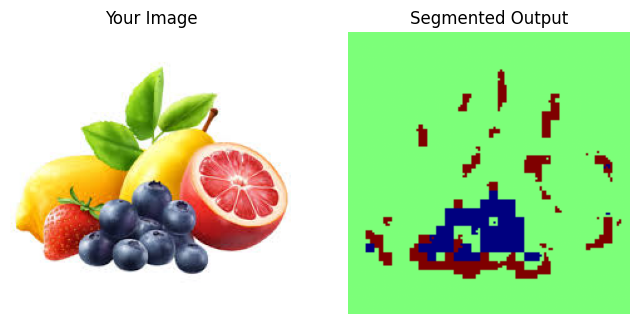

In [7]:
pred = model.predict(np.expand_dims(img_resized, axis=0))
mask = tf.argmax(pred, axis=-1)[0]

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title("Your Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Segmented Output")
plt.imshow(mask, cmap="jet")
plt.axis("off")

plt.show()
